In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'

# this notebook requires the pymc_env environment

Running on PyMC v5.2.0


In [2]:
#read in
dfData=pd.read_csv('data.csv')

#preprocessing names
dfData.dropna()
dfData['name']=dfData.apply(lambda x: x.Supplement+"_custard" if x.Water>0.5 else x.Supplement+"_biscuit", axis=1)
dfData.reset_index(drop=True,inplace=True)

In [3]:
#macronutrient content and other columns
dfData.loc[dfData['type']==1,'texture']=dfData['Biscuit_hardness'].loc[dfData['type']==1]
dfData.loc[dfData['type']==2,'texture']=dfData['Custard_viscosity'].loc[dfData['type']==2]
dfData.loc[dfData['type']==3,'texture']=0
dfData['MacronutrientContent']=dfData['Protein']+dfData['Carbs']+dfData['Fat']
dfData['Total_fibre']=dfData['Soluble_fibre']+dfData['Insoluble_fibre']

In [4]:
#multiple imputation of nan columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

colsForNanImpute = ['Oil_retention', 'Water_retention',
       'Bulk_density', 'Tapped_density', 'L', 'a', 'b', 'C', 'h',
       'Curcumin_binding_capacity','Particle_size', 'Specific_surface_area']
dfData[colsForNanImpute] = dfData[colsForNanImpute].replace({'0':np.nan, 0:np.nan})
numericCols=dfData.select_dtypes(include=np.number).columns.tolist()

imp = IterativeImputer(max_iter=10, random_state=0)

#iterate in each group separately
dfData.loc[dfData['type']==1,numericCols]=imp.fit_transform(dfData[dfData['type']==1][numericCols])
dfData.loc[dfData['type']==2,numericCols]=imp.fit_transform(dfData[dfData['type']==2][numericCols])

In [5]:
#feature selection 1: autofeat
from autofeat import FeatureSelector

autofeatColumns=['Oil_retention', 'Water_retention','Curcumin_binding_capacity',
       'Particle_size',  'Cellulose', 'Hemicellulose',  'Pectin', 'Lignin', 'Fructans','Insoluble_fibre',
       'Soluble_fibre', 'Bulk_density',  'Tapped_density','MacronutrientContent','Total_fibre']

# biscuits
print('biscuits')
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(dfData[dfData['type']==1][autofeatColumns+['Biscuit_hardness']], dfData[dfData['type']==1]['bioaccessibility'])
print(new_X.columns)

# custards
print('custards')
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(dfData[dfData['type']==2][autofeatColumns+['Custard_viscosity','Custard_firmness','Custard_stickiness']], dfData[dfData['type']==2]['bioaccessibility'])
print(new_X.columns)

biscuits
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 6 features after 5 feature selection runs
[featsel] 6 features after correlation filtering
[featsel] 6 features after noise filtering
Index(['Pectin', 'Hemicellulose', 'Insoluble_fibre', 'Oil_retention',
       'Soluble_fibre', 'MacronutrientContent'],
      dtype='object')
custards
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 8 features after 5 feature selection runs
[featsel] 7 features after correlation filtering
[featsel] 6 features after noise filtering
Index(['Soluble_fibre', 'Cellulose', 'Water_retention', 'Custard_firmness',
       'MacronutrientContent', 'Total_fibre'],
      dt

In [6]:
#feature selection 2: Boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

borutaColumns=['Oil_retention', 'Water_retention','Curcumin_binding_capacity',
       'Particle_size', 'Specific_surface_area', 'Cellulose', 'Hemicellulose',  'Pectin', 'Lignin', 'Fructans','Insoluble_fibre',
       'Soluble_fibre', 'Bulk_density',  'Tapped_density','MacronutrientContent','Total_fibre']

# biscuits
print('biscuits')
clf = RandomForestRegressor(n_jobs=-1, max_depth=5)
trans = BorutaPy(clf, n_estimators='auto', verbose=0, random_state=1)
feat_selector = trans.fit(dfData[dfData['type']==1][borutaColumns+['Biscuit_hardness']].values, dfData[dfData['type']==1]['bioaccessibility'].values)
df_filtered=pd.DataFrame(feat_selector.transform(dfData[dfData['type']==1][borutaColumns+['Biscuit_hardness']].values),columns=dfData[dfData['type']==1][borutaColumns+['Biscuit_hardness']].columns[feat_selector.support_])
print(df_filtered.columns)

# custards
print('custards')
clf = RandomForestRegressor(n_jobs=-1, max_depth=5)
trans = BorutaPy(clf, n_estimators='auto', verbose=0, random_state=1)
feat_selector = trans.fit(dfData[dfData['type']==2][borutaColumns+['Custard_viscosity','Custard_firmness','Custard_stickiness']].values, dfData[dfData['type']==2]['bioaccessibility'].values)
df_filtered=pd.DataFrame(feat_selector.transform(dfData[dfData['type']==2][borutaColumns+['Custard_viscosity','Custard_firmness','Custard_stickiness']].values),columns=dfData[dfData['type']==2][borutaColumns+['Custard_viscosity','Custard_firmness','Custard_stickiness']].columns[feat_selector.support_])
print(df_filtered.columns)


biscuits
Index(['Curcumin_binding_capacity', 'Hemicellulose', 'MacronutrientContent'], dtype='object')
custards
Index(['Oil_retention', 'MacronutrientContent'], dtype='object')


In [26]:
# feature selection 3: Lasso priors

priorsLassoLike = {
    "Intercept": bmb.Prior("Normal", mu=13, sigma=10),
    "MacronutrientContent": bmb.Prior("Normal", mu=40,sigma=10),
    "Soluble_fibre|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Insoluble_fibre|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Total_fibre|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Curcumin_binding_capacity|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Bulk_density|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Tapped_density|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Biscuit_hardness|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal",  sigma=10)),
    "Custard_stickiness|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Particle_size|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal",  sigma=10)),
    "Oil_retention|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Water_retention|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Carbs|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Fat|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Water|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Protein|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Lignin|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Pectin|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Fructans|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Hemicellulose|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Cellulose|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "Dextrine|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "texture|type": bmb.Prior("Laplace", mu=0, b=bmb.Prior("HalfNormal", sigma=10)),
    "1|type": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal",  sigma=10)),
    "sigma": bmb.Prior("HalfNormal",sigma=10),
}

# temp dataframe and scaling 0-1
dfData2=dfData.copy()
bioaccessibility=dfData2.copy()['bioaccessibility']
numericCols=dfData2.select_dtypes(include=np.number).columns.tolist()
numericCols.remove("MacronutrientContent")
numericCols.remove("bioaccessibility")
numericCols.remove("type")
scaler=sklearn.preprocessing.MinMaxScaler()

# scale each matrix separately, except for macronutrient content
dfData2.loc[dfData2['type']==1,numericCols]=scaler.fit_transform(dfData2[dfData2['type']==1][numericCols])
dfData2.loc[dfData2['type']==2,numericCols]=scaler.fit_transform(dfData2[dfData2['type']==2][numericCols])
dfData2["MacronutrientContent"]=scaler.fit_transform(dfData2[["MacronutrientContent"]])

# scale texture props separately per matrix type by re-adding later
dfData2.loc[dfData2['type']==1,'texture']=dfData2['Biscuit_hardness'].loc[dfData2['type']==1]
dfData2.loc[dfData2['type']==2,'texture']=dfData2['Custard_viscosity'].loc[dfData2['type']==2]
dfData2.drop(dfData2[dfData2['type']==3].index,inplace=True)

# only including latest combination tested
modelLaplace = bmb.Model("bioaccessibility ~ 1 +MacronutrientContent +(0 + texture|type)+ (0 + Dextrine|type)+(0 + Cellulose|type)+(0 + Hemicellulose|type) +(0 + Pectin|type)+(0 + Soluble_fibre|type)", dfData2, family='t',noncentered=False,priors=priorsLassoLike)
idataLaplace = modelLaplace.fit(target_accept=0.95, tune=2000, draws=2000,idata_kwargs={"log_likelihood": True})



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, texture|type_b, texture|type, Dextrine|type_b, Dextrine|type, Cellulose|type_b, Cellulose|type, Hemicellulose|type_b, Hemicellulose|type, Pectin|type_b, Pectin|type, Soluble_fibre|type_b, Soluble_fibre|type]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 393 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'MacronutrientContent'}>,
        <AxesSubplot:title={'center':'MacronutrientContent'}>],
       [<AxesSubplot:title={'center':'texture|type'}>,
        <AxesSubplot:title={'center':'texture|type'}>],
       [<AxesSubplot:title={'center':'Dextrine|type'}>,
        <AxesSubplot:title={'center':'Dextrine|type'}>],
       [<AxesSubplot:title={'center':'Cellulose|type'}>,
        <AxesSubplot:title={'center':'Cellulose|type'}>],
       [<AxesSubplot:title={'center':'Hemicellulose|type'}>,
        <AxesSubplot:title={'center':'Hemicellulose|type'}>],
       [<AxesSubplot:title={'center':'Pectin|type'}>,
        <AxesSubplot:title={'center':'Pectin|type'}>],
       [<AxesSubplot:title={'center':'Soluble_fibre|type'}>,
        <AxesSubplot:title={'center':'Soluble_fibre|type'}>],
       [<AxesSubplot:title={'center':'bioaccessibility_sigma'}>,
        <

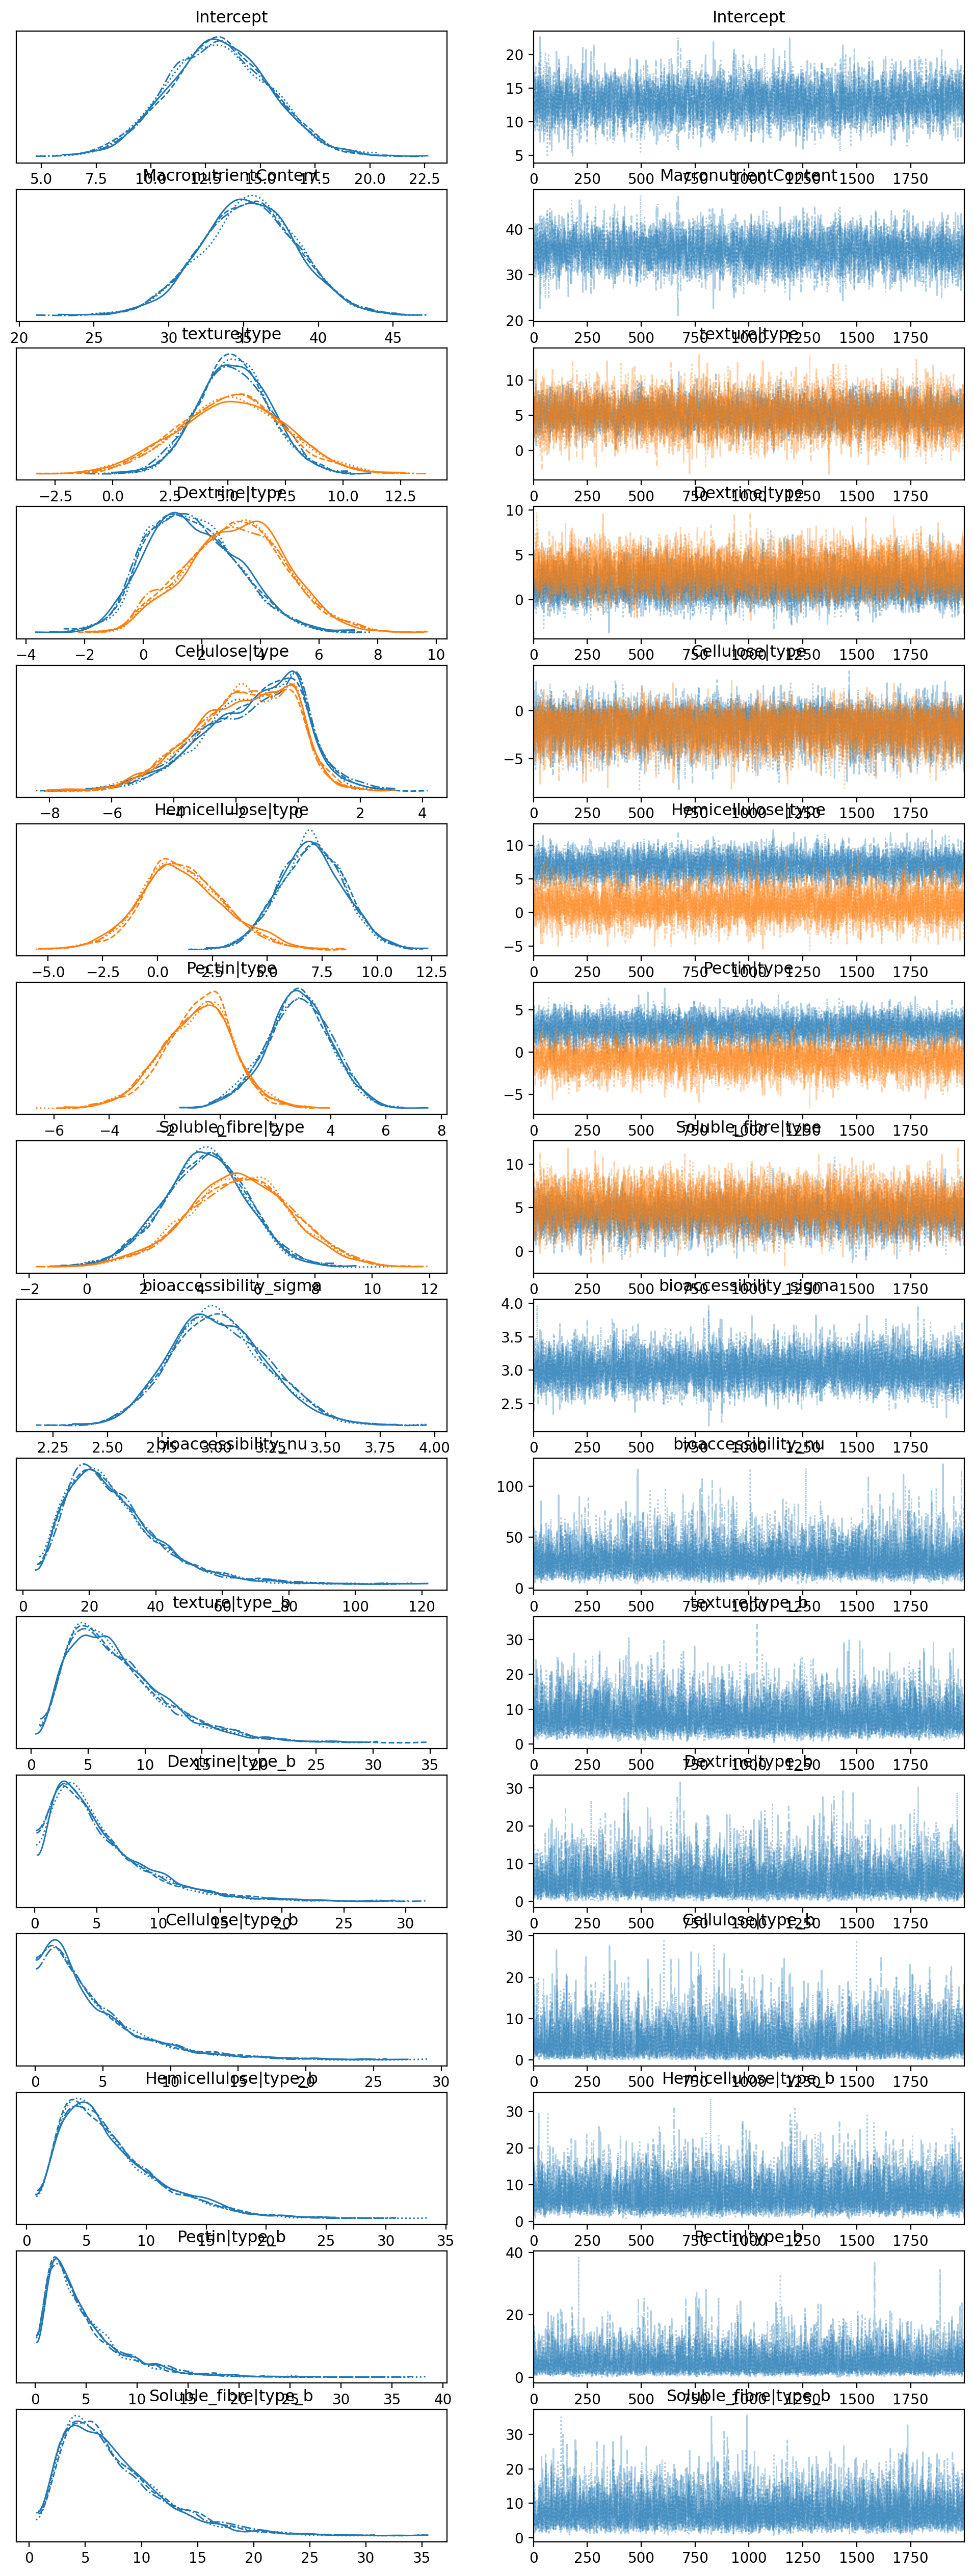

In [27]:
az.plot_trace(idataLaplace)

In [43]:
# fit whole dataset
# data
dfData2=dfData.copy()
allTrainingMac={}

priors = {
"Intercept": bmb.Prior("Normal", mu=13, sigma=10),
"MacronutrientContent": bmb.Prior("Normal", mu=40, sigma=10),
"Soluble_fibre|type": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal",sigma=10)),
"Hemicellulose|type": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal",sigma=10)),
"texture|type": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal",sigma=10))
}

# preprocessing
dfData2['sampleID']=dfData2.apply(lambda x: x.Supplement+" custard" if x.Water>0.5 else x.Supplement+" biscuit",axis=1)
dfData2['sampleID']=dfData2.apply(lambda x: x.sampleID if x.Water<0.9 else x.Supplement,axis=1)
sampleIDs=dfData2.sampleID.to_list()
numericCols=dfData2.select_dtypes(include=np.number).columns.tolist()
numericCols.remove("MacronutrientContent")
numericCols.remove("bioaccessibility")
numericCols.remove("type")
scaler=sklearn.preprocessing.MinMaxScaler()
dfData3=dfData2.copy()
#v scale each matrix separately, except for macronutrient content
dfData3.loc[dfData3['type']==1,numericCols]=scaler.fit_transform(dfData3[dfData3['type']==1][numericCols])
dfData3.loc[dfData3['type']==2,numericCols]=scaler.fit_transform(dfData3[dfData3['type']==2][numericCols])
dfData3["MacronutrientContent"]=scaler.fit_transform(dfData3[["MacronutrientContent"]])
# scale texture props separately per matrix type by re-adding later
dfData3['type']=type
dfData3.loc[dfData3['type']==1,'texture']=dfData3['Biscuit_hardness'].loc[dfData3['type']==1]
dfData3.loc[dfData3['type']==2,'texture']=dfData3['Custard_viscosity'].loc[dfData3['type']==2]
dfData3.loc[dfData3['type']==3,'texture']=0

# fit model across all data (for other combinations, modify this formula)
model = bmb.Model("bioaccessibility ~ 1  + MacronutrientContent + (0+Soluble_fibre|type)+ (0+Hemicellulose|type)", dfData3, family='t',noncentered=True,priors=priors)#many divergences when set to True? it is supposed to be good for low N
idata = model.fit(target_accept=0.95, tune=2000, draws=2000,idata_kwargs={"log_likelihood": True}) 

# iterate over trained samples to obtain goodness-of-fit  
for i in np.unique(sampleIDs):
    print(i)
    test_index=[z for z in range(len(sampleIDs)) if sampleIDs[z] == i]
    print(test_index)
    indexes=list(dfData2.index)
    train_index = [x for x in indexes if x not in test_index]	
    train=dfData3.loc[train_index,:].reset_index(drop=True)
    test=dfData3.loc[test_index,:].reset_index(drop=True)
    model.predict(idata, kind="mean", data=test)
    y_pred_mean = idata.posterior["bioaccessibility_mean"].mean(("chain", "draw")).to_numpy()
    hdi_prob=0.95
    hdi_data=[float(az.hdi(idata, hdi_prob=hdi_prob)['bioaccessibility_mean'][0][0]),float(az.hdi(idata, hdi_prob=hdi_prob)['bioaccessibility_mean'][0][1])]
    print(hdi_data)
    y_test=np.mean(test.bioaccessibility)
    allTrainingMac[i]={'predicted':y_pred_mean,'real':test.bioaccessibility,'hdi':hdi_data}




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 132 seconds.


Ceamfibre 7000 biscuit
[48, 49, 50, 51, 52, 53]
[47.149073482339716, 49.20823735617548]
Ceamfibre 7000 custard
[113, 114, 115, 116, 117, 118]
[27.928885269784523, 30.11963271137391]
FST 00007 KaroPRO 1-26 biscuit
[24, 25, 26, 27, 28, 29]
[50.18941897427777, 52.04673444118281]
FST 00007 KaroPRO 1-26 custard
[86, 87, 88, 89, 90, 91]
[30.023756263282316, 31.526445859993437]
FST 00018 KaroPRO SG biscuit
[30, 31, 32, 33, 34, 35]
[50.18941897427777, 52.04673444118281]
FST 00018 KaroPRO SG custard
[92, 93, 94, 95, 96, 97]
[30.023756263282316, 31.526445859993437]
FST 00224 ApplePRO 60+ biscuit
[15, 16, 17, 18, 19, 20, 21, 22, 23]
[52.94896090342847, 55.12538737877153]
FST 00224 ApplePRO 60+ custard
[80, 81, 82, 83, 84, 85]
[30.181297532130817, 32.26985330317532]
Inulin (Orafti®GR) biscuit
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[47.58473221820192, 51.106398574039105]
Inulin (Orafti®GR) custard
[68, 69, 70, 71, 72, 73]
[31.093409379150803, 34.57046405004891]
Microcrystalline cellulose biscuit
[9, 10, 11, 1

In [31]:
az.summary(idata)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept                 14.820   0.954  12.989   16.642      0.011    0.008  \
MacronutrientContent      38.210   1.606  35.305   41.442      0.024    0.017   
bioaccessibility_sigma     3.516   0.259   3.059    4.020      0.004    0.003   
bioaccessibility_nu       27.266  14.306   5.515   53.370      0.138    0.109   
Soluble_fibre|type_sigma   2.026   0.591   0.908    3.128      0.009    0.006   
Hemicellulose|type_sigma   2.101   0.666   0.910    3.471      0.014    0.010   
Soluble_fibre|type[1]      2.054   1.215  -0.198    4.301      0.020    0.014   
Soluble_fibre|type[2]      3.795   1.235   1.503    6.179      0.019    0.013   
Soluble_fibre|type[3]     -0.002   2.106  -4.094    4.065      0.023    0.024   
Hemicellulose|type[1]      4.270   1.745   1.102    7.755      0.039    0.027   
Hemicellulose|type[2]      2.061   1.240  -0.248    4.292      0.020    0.014   
Hemicellulose|type[3]     -0.040   2.214  -4.215    4.384      0.025    0.025   
bioaccessibility_mean[0]  14.820   0.954  12.989   16.642      0.011    0.008   
bioaccessibility_mean[1]  14.820   0.954  12.989   16.642      0.011    0.008   
bioaccessibility_mean[2]  14.820   0.954  12.989   16.642      0.011    0.008   
bioaccessibility_mean[3]  14.820   0.954  12.989   16.642      0.011    0.008   
bioaccessibility_mean[4]  14.820   0.954  12.989   16.642      0.011    0.008   
bioaccessibility_mean[5]  14.820   0.954  12.989   16.642      0.011    0.008   

                          ess_bulk  ess_tail  r_hat  
Intercept                   7135.0    5444.0    1.0  
MacronutrientContent        4570.0    5809.0    1.0  
bioaccessibility_sigma      5350.0    5389.0    1.0  
bioaccessibility_nu        10357.0    6230.0    1.0  
Soluble_fibre|type_sigma    4572.0    3168.0    1.0  
Hemicellulose|type_sigma    2486.0    1109.0    1.0  
Soluble_fibre|type[1]       3501.0    4174.0    1.0  
Soluble_fibre|type[2]       4489.0    3111.0    1.0  
Soluble_fibre|type[3]       8148.0    5402.0    1.0  
Hemicellulose|type[1]       2110.0    1149.0    1.0  
Hemicellulose|type[2]       3666.0    2229.0    1.0  
Hemicellulose|type[3]       8179.0    5918.0    1.0  
bioaccessibility_mean[0]    7135.0    5444.0    1.0  
bioaccessibility_mean[1]    7135.0    5444.0    1.0  
bioaccessibility_mean[2]    7135.0    5444.0    1.0  
bioaccessibility_mean[3]    7135.0    5444.0    1.0  
bioaccessibility_mean[4]    7135.0    5444.0    1.0  
bioaccessibility_mean[5]    7135.0    5444.0    1.0

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'MacronutrientContent'}>,
        <AxesSubplot:title={'center':'MacronutrientContent'}>],
       [<AxesSubplot:title={'center':'bioaccessibility_sigma'}>,
        <AxesSubplot:title={'center':'bioaccessibility_sigma'}>],
       [<AxesSubplot:title={'center':'bioaccessibility_nu'}>,
        <AxesSubplot:title={'center':'bioaccessibility_nu'}>],
       [<AxesSubplot:title={'center':'Soluble_fibre|type_sigma'}>,
        <AxesSubplot:title={'center':'Soluble_fibre|type_sigma'}>],
       [<AxesSubplot:title={'center':'Hemicellulose|type_sigma'}>,
        <AxesSubplot:title={'center':'Hemicellulose|type_sigma'}>],
       [<AxesSubplot:title={'center':'Soluble_fibre|type'}>,
        <AxesSubplot:title={'center':'Soluble_fibre|type'}>],
       [<AxesSubplot:title={'center':'Hemicellulose|type'}>,
        <AxesSubplot:title={'center':'Hemicellulose|type'}

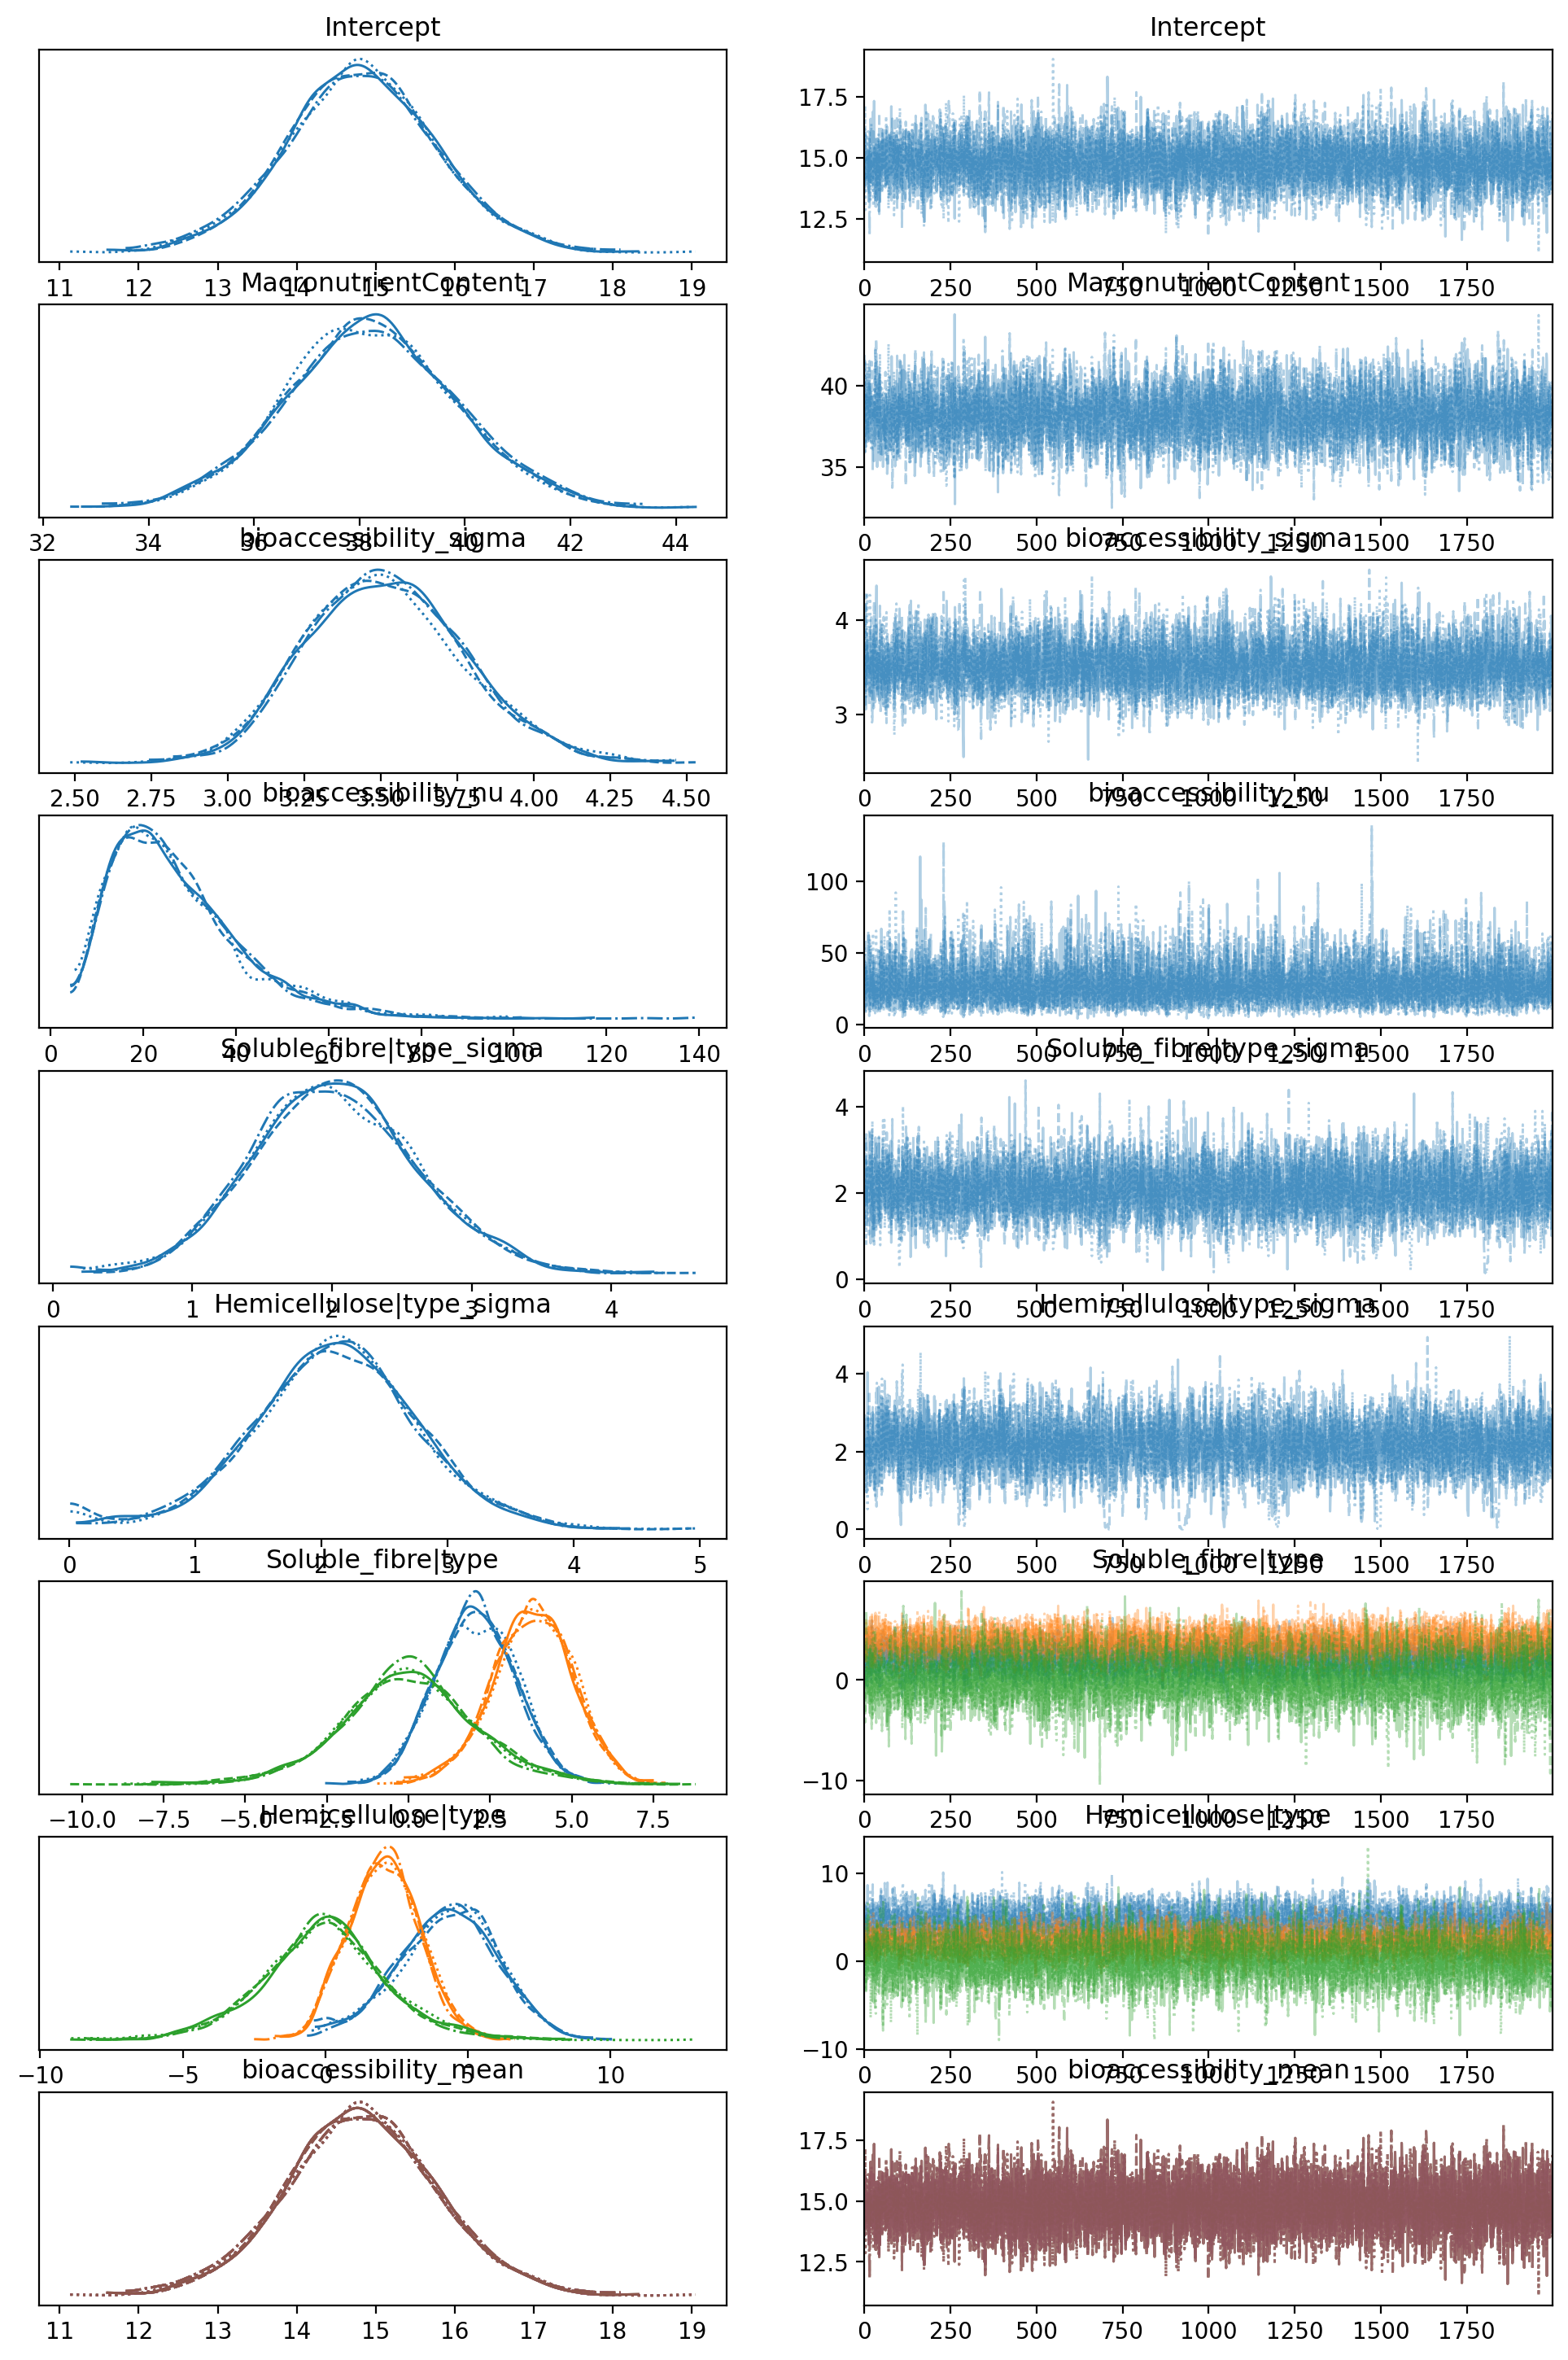

In [32]:
az.plot_trace(idata)

In [36]:
dfData.rename(columns={'Exp. oil retention':'Oil retention','Exp. Water retention final':'Water retention'},inplace=True)
#data
dfData2=dfData.copy()
#plotting
allPredictionsMac={}
shaps={}

# preprocessing
dfData2['sampleID']=dfData2.apply(lambda x: x.Supplement+" custard" if x.Water>0.5 else x.Supplement+" biscuit",axis=1)
dfData2['sampleID']=dfData2.apply(lambda x: x.sampleID if x.Water<0.9 else x.Supplement,axis=1)
sampleIDs=dfData2.sampleID.to_list()
numericCols=dfData2.select_dtypes(include=np.number).columns.tolist()
numericCols.remove("MacronutrientContent")
numericCols.remove("bioaccessibility")
numericCols.remove("type")
scaler=sklearn.preprocessing.MinMaxScaler()
dfData3=dfData2.copy()

# leave-one-out cross validation loop
for i in np.unique(sampleIDs):
    print(i)
    test_index=[z for z in range(len(sampleIDs)) if sampleIDs[z] == i]
    print(test_index)
    indexes=list(dfData2.index)
    train_index = [x for x in indexes if x not in test_index]	
    train=dfData3.loc[train_index,:]
    test=dfData3.loc[test_index,:]
    bioaccessibilityTrain=train.copy()['bioaccessibility']
    typeTrain=train.copy()['type']
    bioaccessibilityTest=test.copy()['bioaccessibility']
    typeTest=test.copy()['type']

    #scale each matrix separately, except for macronutrient content, no need to scale liquids
    train.loc[train['type']==1,numericCols]=scaler.fit_transform(train[train['type']==1][numericCols])
    if typeTest[test_index[0]]==1:
        test.loc[test['type']==1,numericCols]=scaler.transform(test[test['type']==1][numericCols])
    train.loc[train['type']==2,numericCols]=scaler.fit_transform(train[train['type']==2][numericCols])
    if typeTest[test_index[0]]==2:
        test.loc[test['type']==2,numericCols]=scaler.transform(test[test['type']==2][numericCols])
    train["MacronutrientContent"]=scaler.fit_transform(train[["MacronutrientContent"]])
    test["MacronutrientContent"]=scaler.transform(test[["MacronutrientContent"]])

    # nscale texture props separately per matrix type by re-adding later
    train.loc[train['type']==1,'texture']=train['Biscuit_hardness'].loc[train['type']==1]
    train.loc[train['type']==2,'texturePropsIdeal']=train['Custard_viscosity'].loc[train['type']==2]
    train.loc[train['type']==3,'texturePropsIdeal']=0

    # tests
    if typeTest[test_index[0]]==1:
        test.loc[test['type']==1,'texture']=test['Biscuit_hardness'].loc[test['type']==1]
    elif typeTest[test_index[0]]==2:
        test.loc[test['type']==2,'texture']=test['Custard_viscosity'].loc[test['type']==2]
    else:
        test.loc[test['type']==3,'texture']=0

    train['bioaccessibility']=bioaccessibilityTrain
    train['type']=typeTrain
    test['bioaccessibility']=bioaccessibilityTest
    test['type']=typeTest

    # fit model across training data (for other combinations, modify this formula)
    model = bmb.Model("bioaccessibility ~ 1  + MacronutrientContent + (0+Soluble_fibre|type)+ (0+Hemicellulose|type)", train, family='t',noncentered=True,priors=priors)
    idata = model.fit(target_accept=0.95, tune=2000, draws=2000,idata_kwargs={"log_likelihood": True})  

    # predict test sample
    model.predict(idata, kind="mean", data=test)
    y_pred_mean = idata.posterior["bioaccessibility_mean"].mean(("chain", "draw")).to_numpy()
    hdi_prob=0.95
    hdi_data=[float(az.hdi(idata, hdi_prob=hdi_prob)['bioaccessibility_mean'][0][0]),float(az.hdi(idata, hdi_prob=hdi_prob)['bioaccessibility_mean'][0][1])]
    print(hdi_data)
    y_test=np.mean(test.bioaccessibility)
    allPredictionsMac[i]={'predicted':y_pred_mean,'real':test.bioaccessibility,'hdi':hdi_data}




Ceamfibre 7000 biscuit
[48, 49, 50, 51, 52, 53]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 123 seconds.


[46.64009798342047, 48.97050101358951]
Ceamfibre 7000 custard
[113, 114, 115, 116, 117, 118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 108 seconds.


[27.655728899608956, 29.99805650773305]
FST 00007 KaroPRO 1-26 biscuit
[24, 25, 26, 27, 28, 29]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 96 seconds.


[50.18816133722252, 52.288023399879805]
FST 00007 KaroPRO 1-26 custard
[86, 87, 88, 89, 90, 91]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 95 seconds.


[29.97155175876789, 31.57702643543165]
FST 00018 KaroPRO SG biscuit
[30, 31, 32, 33, 34, 35]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 101 seconds.


[50.04175653073417, 52.097171459666015]
FST 00018 KaroPRO SG custard
[92, 93, 94, 95, 96, 97]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 94 seconds.


[30.094107408549828, 31.73078512554954]
FST 00224 ApplePRO 60+ biscuit
[15, 16, 17, 18, 19, 20, 21, 22, 23]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 93 seconds.


[52.870545678504875, 55.41287806632304]
FST 00224 ApplePRO 60+ custard
[80, 81, 82, 83, 84, 85]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 103 seconds.


[29.952273442487087, 32.13466373412787]
Inulin (Orafti®GR) biscuit
[0, 1, 2, 3, 4, 5, 6, 7, 8]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 120 seconds.


[47.252441888995236, 52.166359840817265]
Inulin (Orafti®GR) custard
[68, 69, 70, 71, 72, 73]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 101 seconds.


[30.13776974580169, 35.021813441307074]
Microcrystalline cellulose biscuit
[9, 10, 11, 12, 13, 14]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 95 seconds.


[44.77720280272369, 47.922558145770324]
Microcrystalline cellulose custard
[74, 75, 76, 77, 78, 79]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.


[26.692049810127536, 29.54661729318003]
Nutriose FM06 biscuit
[42, 43, 44, 45, 46, 47]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 94 seconds.


[44.81807968958866, 48.52018005407258]
Nutriose FM06 custard
[104, 105, 106, 107, 108, 109, 110, 111, 112]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.


[26.97717900140232, 30.952461269240516]
Pea fiber 50 M biscuit
[36, 37, 38, 39, 40, 41]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.


[57.3326984836291, 62.477655875643784]
Pea fiber 50 M custard
[98, 99, 100, 101, 102, 103]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 103 seconds.


[28.927666041195614, 33.58322795250309]
Vitacel WF200 biscuit
[54, 55, 56, 57, 58, 59]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.


[45.54450047371942, 48.66551959731785]
Vitacel WF200 custard
[119, 120, 121, 122, 123]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 109 seconds.


[28.33356617903712, 31.680718889899012]
milk
[130, 131, 132]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 106 seconds.


[16.783854111084132, 20.010647627857647]
non-supplemented biscuit
[60, 61, 62, 63, 64, 65, 66, 67]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 113 seconds.


[46.316986902382254, 49.98234302316818]
non-supplemented custard
[124, 125, 126, 127, 128, 129]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 108 seconds.


[27.364232401008838, 30.05382551811003]
water
[133, 134, 135, 136, 137, 138]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bioaccessibility_sigma, bioaccessibility_nu, Intercept, MacronutrientContent, Soluble_fibre|type_sigma, Soluble_fibre|type_offset, Hemicellulose|type_sigma, Hemicellulose|type_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 107 seconds.


[14.135109992945297, 19.009731000935737]


In [ ]:
import pickle

# for saving and loading previous results, if necessary
#with open('allTrainingMac_SolubleHemic.pkl', 'rb') as fp:
    #pickle.dump(allTrainingMac,fp)
    #allTrainingMac=pickle.load(fp)

In [37]:
# positioning dictionaries for results plot
positionsDictTrain={'FST 00224 ApplePRO 60+ biscuit': {'x': -1.7, 'y': 0.3, 'label': '5'},
 'FST 00224 ApplePRO 60+ custard': {'x': -0.8, 'y': 1.8, 'label': '5'},
 'Ceamfibre 7000 biscuit': {'x': 0.2, 'y': -0.3, 'label': '7'},
 'Ceamfibre 7000 custard': {'x': 0, 'y': -1.15, 'label': '7'},
 'Microcrystalline cellulose biscuit': {'x': -1.7, 'y': 0, 'label': '9'},
 'Microcrystalline cellulose custard': {'x': -1.7, 'y': 0, 'label': '9'},
 'Inulin (Orafti®GR) biscuit': {'x': -1.7, 'y': 0, 'label': '1'},
 'Inulin (Orafti®GR) custard': {'x': -1.7, 'y': 0, 'label': '1'},
 'FST 00007 KaroPRO 1-26 biscuit': {'x': -1.7, 'y': -0.2, 'label': '3'},
 'FST 00007 KaroPRO 1-26 custard': {'x': -0.8, 'y': -1.7, 'label': '3'},
 'FST 00018 KaroPRO SG biscuit': {'x': 0, 'y': 0, 'label': '4'},
 'FST 00018 KaroPRO SG custard': {'x': -1.9, 'y': 0, 'label': '4'},
 'Nutriose FM06 biscuit': {'x': 0.3, 'y': -1.25, 'label': '2'},
 'Nutriose FM06 custard': {'x': 0.6, 'y': -0.25, 'label': '2'},
 'Pea fiber 50 M biscuit': {'x': 0, 'y': 0, 'label': '6'},
 'Pea fiber 50 M custard': {'x': 0, 'y': 0, 'label': '6'},
 'Vitacel WF200 biscuit': {'x': 0, 'y': -0.3, 'label': '8'},
 'Vitacel WF200 custard': {'x': -1.7, 'y': 0, 'label': '8'},
 'milk': {'x': 0, 'y': 0, 'label': 'Milk'},
 'non-supplemented biscuit': {'x': 0.1, 'y': -0.2, 'label': '10'},
 'non-supplemented custard': {'x': 0.3, 'y': -0.45, 'label': '10'},
 'water': {'x': 0, 'y': 0, 'label': 'Water'}}
positionsDictLOO={'FST 00224 ApplePRO 60+ biscuit': {'x': -1.7, 'y': 0.3, 'label': '5'},
 'FST 00224 ApplePRO 60+ custard': {'x': -0.8, 'y': 1.8, 'label': '5'},
 'Ceamfibre 7000 biscuit': {'x': 0.2, 'y': -0.3, 'label': '7'},
 'Ceamfibre 7000 custard': {'x': 0, 'y': -1, 'label': '7'},
 'Microcrystalline cellulose biscuit': {'x': -1.7, 'y': 0, 'label': '9'},
 'Microcrystalline cellulose custard': {'x': -1.7, 'y': 0, 'label': '9'},
 'Inulin (Orafti®GR) biscuit': {'x': -1.7, 'y': 0, 'label': '1'},
 'Inulin (Orafti®GR) custard': {'x': -1.7, 'y': 0, 'label': '1'},
 'FST 00007 KaroPRO 1-26 biscuit': {'x': -1.7, 'y': -0.2, 'label': '3'},
 'FST 00007 KaroPRO 1-26 custard': {'x': -0.8, 'y': -1.7, 'label': '3'},
 'FST 00018 KaroPRO SG biscuit': {'x': 0, 'y': 0, 'label': '4'},
 'FST 00018 KaroPRO SG custard': {'x': -1.9, 'y': 0, 'label': '4'},
 'Nutriose FM06 biscuit': {'x': 0, 'y': -1.2, 'label': '2'},
 'Nutriose FM06 custard': {'x': 0.6, 'y': 0, 'label': '2'},
 'Pea fiber 50 M biscuit': {'x': 0, 'y': 0, 'label': '6'},
 'Pea fiber 50 M custard': {'x': 0, 'y': 0, 'label': '6'},
 'Vitacel WF200 biscuit': {'x': 0, 'y': 0, 'label': '8'},
 'Vitacel WF200 custard': {'x': -1.7, 'y': 0, 'label': '8'},
 'milk': {'x': 0, 'y': 0, 'label': 'Milk'},
 'non-supplemented biscuit': {'x': 0.1, 'y': -0.2, 'label': '10'},
 'non-supplemented custard': {'x': 0.3, 'y': -0.45, 'label': '10'},
 'water': {'x': 0, 'y': 0, 'label': 'Water'}}

Colour interference assessment 
custards- R2: 0.71, RMSE:1.52, MAE: 1.38
biscuits- R2: 0.73, RMSE:2.21, MAE: 1.86
[[50.39795876, 48.0542896, 47.17684152, 52.58738561, 49.55883121, 48.23684216], [33.99578007, 32.89552906, 31.08788272, 28.47076524, 30.20328934, 25.15280732], [55.7430396, 55.3682312, 52.46547011, 54.26799766, 51.80153356, 48.25990682], [31.15006295, 28.03336312, 27.75268068, 32.87662445, 33.76324197, 36.49040503], [58.6494371, 56.21301857, 57.4213433, 55.14029182, 49.52079904, 46.64939592], [30.78004338, 28.23399625, 31.62140651, 27.25477189, 31.26092346, 26.12945108], [53.84329564, 51.68001052, 48.37853665, 51.19326038, 54.24169858, 57.44773685, 52.29983966, 53.70611798, 58.80418131], [31.46258779, 31.63898194, 33.2599401, 34.71836262, 31.78007276, 29.71996328], [49.80516688, 47.75279722, 45.44015576, 50.73994685, 45.7586869, 45.65418558, 50.99155472, 45.03966161, 52.94222579], [34.09380726, 29.22066875, 28.32672905, 32.77212723, 32.98683858, 29.2815967], [42.40245669, 4

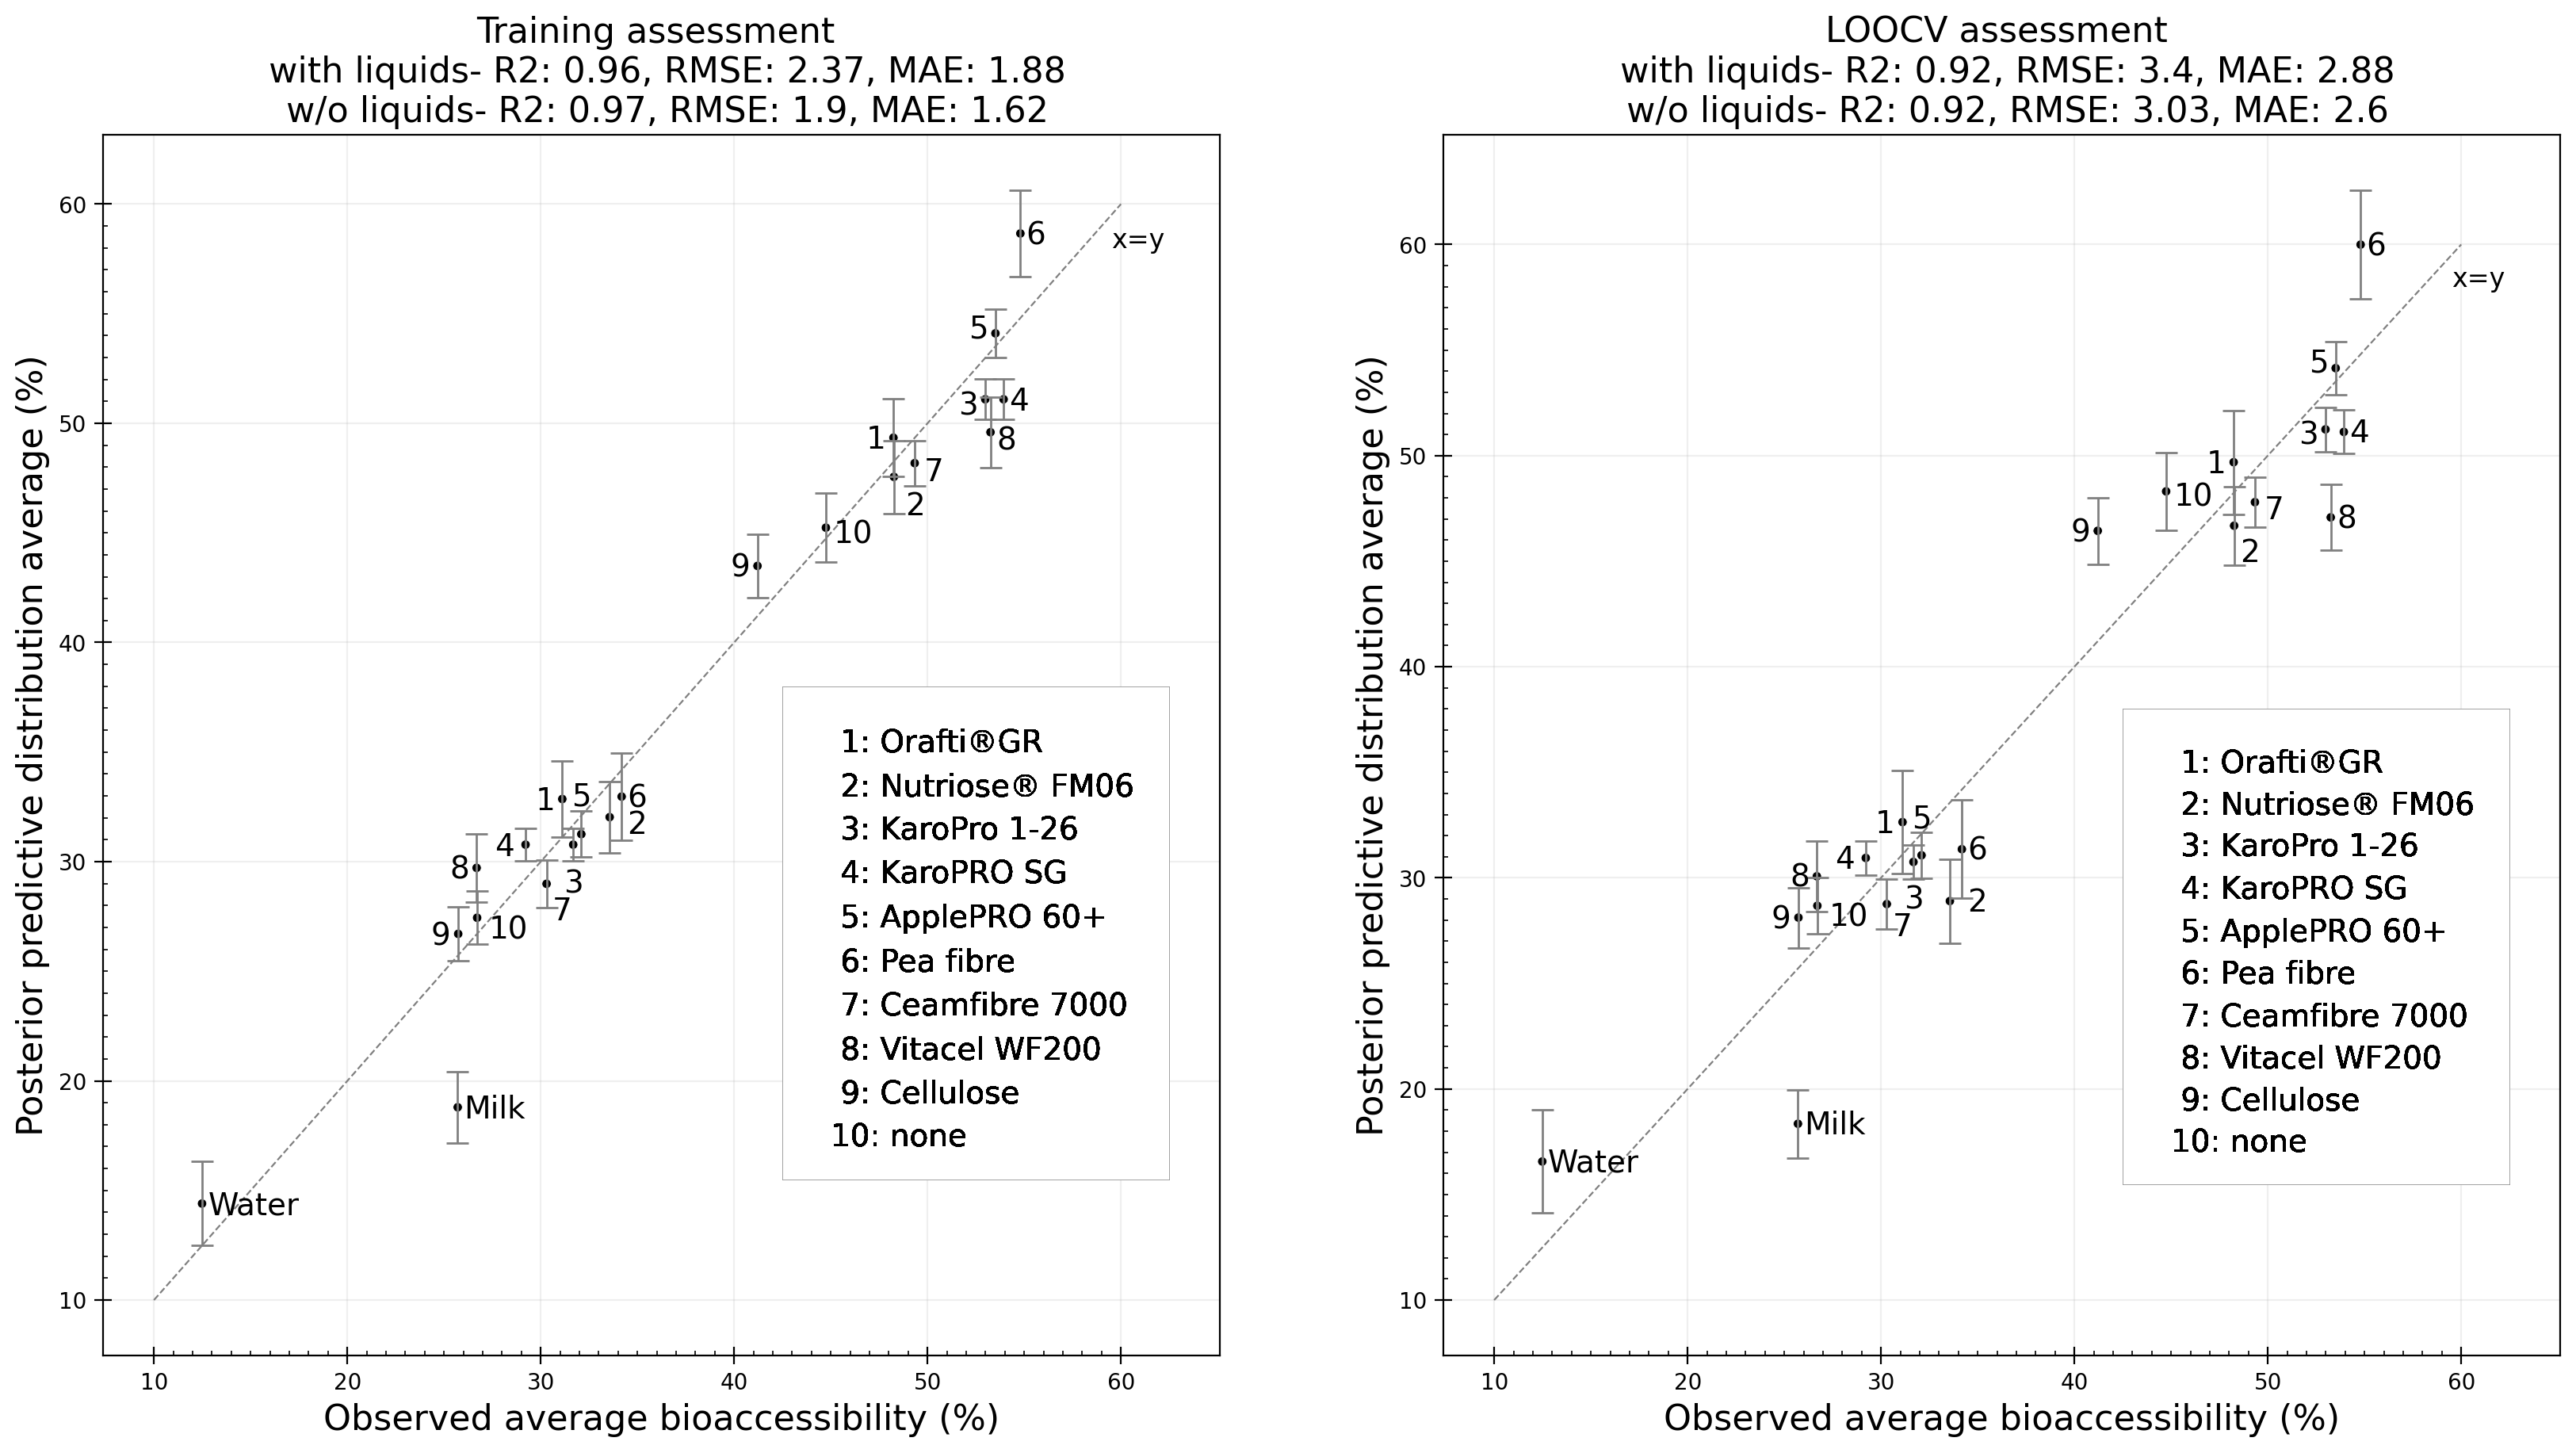

In [44]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np 

# plot observed vs predicted of goodness-of-fit and LOOCV
plt.style.use('default')
             
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20, 10)



predicted_cust=[np.mean(value['predicted']) for i,value in allTrainingMac.items() if 'custard' in i]
real_cust=[np.mean(value['real']) for i,value in allTrainingMac.items() if 'custard' in i]
predicted_bisc=[np.mean(value['predicted']) for i,value in allTrainingMac.items() if 'biscuit' in i]
real_bisc=[np.mean(value['real']) for i,value in allTrainingMac.items() if 'biscuit' in i]
print("Colour interference assessment \ncustards- R2: "+ str(round(r2_score(real_cust,predicted_cust),2))+", RMSE:"+str(round(np.sqrt(mean_squared_error(predicted_cust,real_cust)),2))+", MAE: "+str(round(mean_absolute_error(predicted_cust,real_cust),2))+"\nbiscuits- R2: "+ str(round(r2_score(real_bisc,predicted_bisc),2))+", RMSE:"+str(round(np.sqrt(mean_squared_error(real_bisc,predicted_bisc)),2))+", MAE: "+str(round(mean_absolute_error(real_bisc,predicted_bisc),2)))


observationsX=[list(value['real']) for i,value in allTrainingMac.items()]
observationsY=[[np.mean(value['predicted'])]*len(list(value['real'])) for i,value in allTrainingMac.items()]
allobsX=[item for sublist in observationsX for item in sublist]
allobsY=[item for sublist in observationsY for item in sublist]
real=[np.mean(value['predicted']) for i,value in allTrainingMac.items()]
predicted=[np.mean(value['real']) for i,value in allTrainingMac.items()]
errors=[[value['hdi'][0],value['hdi'][1]] for i,value in allTrainingMac.items()]
print(observationsX)
print(observationsY)
ids=[i for i in allTrainingMac.keys() ]
labels=[[i] for i in ids]
print(ids)
print(labels)

realNoLiquids=[np.mean(value['predicted']) for i,value in allTrainingMac.items() if len(i.split(' '))>1]
predictedNoLiquids=[np.mean(value['real']) for i,value in allTrainingMac.items() if len(i.split(' '))>1]
colors = dict(zip(ids, sns.color_palette('colorblind', len(ids)).as_hex()))
colorValues=[colors[i] for i in ids]

sns.scatterplot(size=0.5,color='black',ax=axes[0],data=pd.DataFrame({'x':predicted,'y':real,'hue':ids}).explode(['x','y']),x='x',y='y')#,hue='hue',palette=colors

axes[0].set_title("Training assessment \n with liquids- R2: "+str(round(r2_score(predicted,real),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(predicted,real)),2))+", MAE: "+str(round(mean_absolute_error(predicted,real),2))+"\n w/o liquids- R2: "+str(round(r2_score(predictedNoLiquids,realNoLiquids),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(predictedNoLiquids,realNoLiquids)),2))+", MAE: "+str(round(mean_absolute_error(predictedNoLiquids,realNoLiquids),2)),fontsize=16)
axes[0].set_xlabel('Observed average bioaccessibility (%)',fontsize=16)
axes[0].set_ylabel('Posterior predictive distribution average (%)',fontsize=16)
axes[0].plot([10,60], [10,60], marker = None,linestyle= '--',linewidth=0.8,color='grey')
axes[0].text(x=59.5, y=58, s='x=y',fontsize=12)
for x in range(len(predicted)):
    minimumHDI=errors[x][0]
    maxHDI=errors[x][1]
    polygon = patches.Rectangle([minimumHDI,real[x]-0.125],width=maxHDI-minimumHDI,height=0.25,alpha=.5,facecolor='grey')
    axes[0].legend().remove()
    axes[0].text(x=predicted[x]+positionsDictTrain[list(ids)[x]]['x']+0.3, y=real[x]-0.5+positionsDictTrain[list(ids)[x]]['y'], s=positionsDictTrain[list(ids)[x]]['label'],fontsize=14)
    axes[0].errorbar(predicted[x], real[x], yerr=(errors[x][1]-errors[x][0])/2, fmt='none', capsize=5,elinewidth=1, zorder=1, color='grey')
    if 'arrow' in positionsDictTrain[list(ids)[x]]:
        arrow=positionsDictTrain[list(ids)[x]]['arrow']
        axes[0].arrow(predicted[x]+positionsDictTrain[list(ids)[x]]['x']+arrow[0], real[x]-0.5+positionsDictTrain[list(ids)[x]]['y']+arrow[1], arrow[2], arrow[3], width = 0.002, head_width=0.25,color='gray')
    from matplotlib.patches import Rectangle
    axes[0].set_axisbelow(True)
    axes[0].add_patch(Rectangle((42.5, 15.5), 20, 22.5,edgecolor='gray',fill=True,facecolor='white',lw=0.2))
    axes[0].text(x=45, y=35, s=' 1: Orafti®GR',fontsize=14)
    axes[0].text(x=45, y=33, s=' 2: Nutriose® FM06',fontsize=14)
    axes[0].text(x=45, y=31, s=' 3: KaroPro 1-26',fontsize=14)
    axes[0].text(x=45, y=29, s=' 4: KaroPRO SG',fontsize=14)
    axes[0].text(x=45, y=27, s=' 5: ApplePRO 60+',fontsize=14)
    axes[0].text(x=45, y=25, s=' 6: Pea fibre',fontsize=14)
    axes[0].text(x=45, y=23, s=' 7: Ceamfibre 7000',fontsize=14)
    axes[0].text(x=45, y=21, s=' 8: Vitacel WF200',fontsize=14)
    axes[0].text(x=45, y=19, s=' 9: Cellulose',fontsize=14)
    axes[0].text(x=45, y=17, s='10: none',fontsize=14)

axes[0].set_xticks(np.arange(10,60, 1.0),minor=True,labels=None,fontsize=11)
axes[0].set_yticks(np.arange(10,60, 1.0),minor=True,labels=None,fontsize=11)
axes[0].tick_params(which='minor', length=2, color='black',direction='in')
axes[0].tick_params(which='major', length=8, color='black',direction='inout')
axes[0].grid(which='major', visible=True,alpha=0.2)

predicted_cust=[np.mean(value['predicted']) for i,value in allPredictionsMac.items() if 'custard' in i]
real_cust=[np.mean(value['real']) for i,value in allPredictionsMac.items() if 'custard' in i]
predicted_bisc=[np.mean(value['predicted']) for i,value in allPredictionsMac.items() if 'biscuit' in i]
real_bisc=[np.mean(value['real']) for i,value in allPredictionsMac.items() if 'biscuit' in i]
print("Colour interference assessment \ncustards- R2: "+ str(round(r2_score(real_cust,predicted_cust),2))+", RMSE:"+str(round(np.sqrt(mean_squared_error(predicted_cust,real_cust)),2))+", MAE: "+str(round(mean_absolute_error(predicted_cust,real_cust),2))+"\nbiscuits- R2: "+ str(round(r2_score(real_bisc,predicted_bisc),2))+", RMSE:"+str(round(np.sqrt(mean_squared_error(real_bisc,predicted_bisc)),2))+", MAE: "+str(round(mean_absolute_error(real_bisc,predicted_bisc),2)))

observationsX=[list(value['real']) for i,value in allPredictionsMac.items()]
observationsY=[[np.mean(value['predicted'])]*len(list(value['real'])) for i,value in allPredictionsMac.items()]
allobsX=[item for sublist in observationsX for item in sublist]
allobsY=[item for sublist in observationsY for item in sublist]
real=[np.mean(value['predicted']) for i,value in allPredictionsMac.items()]
predicted=[np.mean(value['real']) for i,value in allPredictionsMac.items()]
errors=[[value['hdi'][0],value['hdi'][1]] for i,value in allPredictionsMac.items()]
ids=[i for i in allTrainingMac.keys() ]
labels=[[i] for i in ids]

realNoLiquids=[np.mean(value['predicted']) for i,value in allPredictionsMac.items() if len(i.split(' '))>1]
predictedNoLiquids=[np.mean(value['real']) for i,value in allPredictionsMac.items() if len(i.split(' '))>1]

colors = dict(zip(ids, sns.color_palette('colorblind', len(ids)).as_hex()))
colorValues=[colors[i] for i in ids]

sns.scatterplot(size=0.5,color='black',ax=axes[1],data=pd.DataFrame({'x':predicted,'y':real,'hue':ids}).explode(['x','y']),x='x',y='y')

axes[1].set_title("LOOCV assessment \n with liquids- R2: "+str(round(r2_score(predicted,real),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(predicted,real)),2))+", MAE: "+str(round(mean_absolute_error(predicted,real),2))+"\n w/o liquids- R2: "+str(round(r2_score(predictedNoLiquids,realNoLiquids),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(predictedNoLiquids,realNoLiquids)),2))+", MAE: "+str(round(mean_absolute_error(predictedNoLiquids,realNoLiquids),2)),fontsize=16)
axes[1].set_xlabel('Observed average bioaccessibility (%)',fontsize=16)
axes[1].set_ylabel('Posterior predictive distribution average (%)',fontsize=16)
axes[1].plot([10,60], [10,60], marker = None,linestyle= '--',linewidth=0.8,color='grey')
axes[1].text(x=59.5, y=58, s='x=y',fontsize=12)
axes[1].set_xticks(np.arange(10,60, 1.0),minor=True,labels=None,fontsize=11)
axes[1].set_yticks(np.arange(10,60, 1.0),minor=True,labels=None,fontsize=11)
axes[1].tick_params(which='minor', length=2, color='black',direction='in')
axes[1].tick_params(which='major', length=8, color='black',direction='inout')
axes[1].grid(which='major', visible=True,alpha=0.2)
positionsDict={list(ids)[x]:{'x':0,'y':0,'label':list(ids)[x]} for x in range(len(predicted))}
for x in range(len(predicted)):
    minimumHDI=errors[x][0]
    maxHDI=errors[x][1]
    polygon = patches.Rectangle([minimumHDI,real[x]-0.125],width=maxHDI-minimumHDI,height=0.25,alpha=.5,facecolor='grey')
    axes[1].legend().remove()
    axes[1].text(x=predicted[x]+positionsDictLOO[list(ids)[x]]['x']+0.3, y=real[x]-0.5+positionsDictLOO[list(ids)[x]]['y'], s=positionsDictLOO[list(ids)[x]]['label'],fontsize=14)
    axes[1].errorbar(predicted[x], real[x], yerr=(errors[x][1]-errors[x][0])/2, fmt='none', capsize=5,elinewidth=1, zorder=1, color='grey')
    if 'arrow' in positionsDictLOO[list(ids)[x]]:
        arrow=positionsDictLOO[list(ids)[x]]['arrow']
        plt.arrow(predicted[x]+positionsDictLOO[list(ids)[x]]['x']+arrow[0], real[x]-0.5+positionsDictLOO[list(ids)[x]]['y']+arrow[1], arrow[2], arrow[3], width = 0.002, head_width=0.25,color='gray')
    from matplotlib.patches import Rectangle
    axes[1].set_axisbelow(True)
    axes[1].add_patch(Rectangle((42.5, 15.5), 20, 22.5,edgecolor='gray',fill=True,facecolor='white',lw=0.2))
    axes[1].text(x=45, y=35, s=' 1: Orafti®GR',fontsize=14)
    axes[1].text(x=45, y=33, s=' 2: Nutriose® FM06',fontsize=14)
    axes[1].text(x=45, y=31, s=' 3: KaroPro 1-26',fontsize=14)
    axes[1].text(x=45, y=29, s=' 4: KaroPRO SG',fontsize=14)
    axes[1].text(x=45, y=27, s=' 5: ApplePRO 60+',fontsize=14)
    axes[1].text(x=45, y=25, s=' 6: Pea fibre',fontsize=14)
    axes[1].text(x=45, y=23, s=' 7: Ceamfibre 7000',fontsize=14)
    axes[1].text(x=45, y=21, s=' 8: Vitacel WF200',fontsize=14)
    axes[1].text(x=45, y=19, s=' 9: Cellulose',fontsize=14)
    axes[1].text(x=45, y=17, s='10: none',fontsize=14)

x_min, x_max = axes[0].get_xlim()
y_min, y_max = axes[0].get_ylim()
axes[0].add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color="white", zorder=-1))
x_min, x_max = axes[1].get_xlim()
y_min, y_max = axes[1].get_ylim()
axes[1].add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color="white", zorder=-1))
plt.savefig('demo.png', transparent=True, dpi=300)

plt.show()
